In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

warnings.simplefilter("ignore")
%matplotlib inline
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("ggplot")

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

## 0.Data load

In [2]:
# # choongs load
# df_cust = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")
# df_cop_u = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
# df_pd_clac = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")

In [3]:
# ## osy load
# df_cust = pd.read_csv("../../LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../../LPOINT_BIG_COMP_02_PDDE.csv")
# df_cop_u = pd.read_csv("../../LPOINT_BIG_COMP_03_COP_U.csv")
# df_pd_clac = pd.read_csv("../../LPOINT_BIG_COMP_04_PD_CLAC.csv")

In [2]:
# rnch load
df_cust = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
df_pdde = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")
df_cop_u = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
df_pd_clac = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")

# 1.Domain Clustering Function
---

In [3]:
#DBSCAN을 통해 이상치 제거
def delete_outlier_DBSCAN(df_pdde, df_pd_clac):
    df_pdde_pd_clac = df_pdde.merge(df_pd_clac, how='left', on='pd_c')
    df_pt = pd.pivot_table(data=df_pdde_pd_clac,
               values='buy_am',
               index='cust',
               columns='clac_hlv_nm',
               aggfunc='sum',
               fill_value=0)
    df_pt.reset_index(inplace=True)

    scaler = MinMaxScaler()
    scaler.fit(df_pt.iloc[:,1:])
    df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
    df_spt_2 =  df_spt.reset_index()

    eps_ratio_outlier_dict = dict()
    for epss in tqdm(list(np.arange(0.05, 0.15, 0.01))):
        dbscan = DBSCAN(eps = epss, min_samples = 30, metric = "euclidean")
        dbscan_labels = dbscan.fit_predict(df_spt_2.iloc[:, 1:])
        ratio_outlier = np.unique(dbscan_labels, return_counts=True)[1][0]/np.unique(dbscan_labels, return_counts=True)[1].sum()
        eps_ratio_outlier_dict[epss] = abs(ratio_outlier-0.05) #딕셔너리 Value는 이상치-0.05의 절댓값 -> 즉 0.05에 가장 가까운 값을 찾는다.

    best_eps = min(eps_ratio_outlier_dict,key=eps_ratio_outlier_dict.get)
    

    dbscan = DBSCAN(eps = best_eps, min_samples = 30, metric = "euclidean")
    dbscan_labels = dbscan.fit_predict(df_spt_2.iloc[:, 1:])
    df_spt_2['outlier'] = dbscan_labels

    df_spt_not_outlier_cust = df_spt_2[df_spt_2['outlier']==0]['cust']
    
    return df_spt_not_outlier_cust



# 누락 데이터 삭제
def check_on_off(df_main, df, key="cust", col_nm="chnl_dv"):
    df_new = pd.DataFrame(df.groupby(key)[col_nm].apply(lambda x:list(set(x))))
    return df_main.merge(df_new, how="left", on=key).dropna(subset=["chnl_dv"])



# on/off 분류
def split_on_off(df, col_nm="chnl_dv"):
    df[col_nm] = df[col_nm].apply(lambda x: x[0] if len(x)==1 else 0)
    df_off = df.loc[df[col_nm]==1] ##off
    df_on = df.loc[df[col_nm]==2] ##on
    df_onf = df.loc[df[col_nm]==0] ##onf

    df_not_off = pd.concat([df_on, df_onf], axis=0, ignore_index=True)


    return df_off, df_not_off #off, not_off

def classification_buy_am(x, std_points):
    if x <= std_points[0]:
        return "D"
    elif std_points[0] < x <= std_points[1]:
        return "C"
    elif std_points[1] < x <= std_points[2]:
        return "B"
    else:
        return "A"

def split_buy_amount_by_4(df_main, df_sub, key='cust', col_nm='buy_am'):
    df_new = df_sub.groupby([key], as_index=False)[col_nm].sum()
    df_new2 = df_main.merge(df_new, on='cust', how='left')
    df_new2["am_class"] = df_new2[col_nm].apply(classification_buy_am, std_points=np.quantile(df_new2[col_nm], [.25, .5, .75]))
    

    df_A = df_new2[df_new2['am_class']=='A']
    df_B = df_new2[df_new2['am_class']=='B']
    df_C = df_new2[df_new2['am_class']=='C']
    df_D = df_new2[df_new2['am_class']=='D']
    
    return df_A, df_B, df_C, df_D
    

def domain_clustering_ver2(df_main, df_sub, df_sub2):

    not_outlier_cust = delete_outlier_DBSCAN(df_sub, df_sub2)

    df_main = df_main.loc[df_main['cust'].isin(not_outlier_cust.values.tolist())]

    df = check_on_off(df_main, df_sub)

    df_off, df_not_off= split_on_off(df)

    
    df_off_A, df_off_B, df_off_C, df_off_D  = split_buy_amount_by_4(df_off, df_sub)
    df_not_off_A, df_not_off_B, df_not_off_C, df_not_off_D  = split_buy_amount_by_4(df_not_off, df_sub)

    df_off_A['cluster'] = 0
    df_off_B['cluster'] = 1
    df_off_C['cluster'] = 2
    df_off_D['cluster'] = 3
    df_not_off_A['cluster'] = 4
    df_not_off_B['cluster'] = 5
    df_not_off_C['cluster'] = 6
    df_not_off_D['cluster'] = 7

    df_off_A_label = df_off_A[['cust', 'cluster']]
    df_off_B_label = df_off_B[['cust', 'cluster']]
    df_off_C_label = df_off_C[['cust', 'cluster']]
    df_off_D_label = df_off_D[['cust', 'cluster']]
    df_not_off_A_label = df_not_off_A[['cust', 'cluster']]
    df_not_off_B_label = df_not_off_B[['cust', 'cluster']]
    df_not_off_C_label = df_not_off_C[['cust', 'cluster']]
    df_not_off_D_label = df_not_off_D[['cust', 'cluster']]
    

        
    return df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label

In [4]:
df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label = domain_clustering_ver2(df_cust, df_pdde, df_pd_clac) 

  0%|          | 0/10 [00:00<?, ?it/s]

# 2.K means Clustering Function

In [5]:
### 아래 함수에서 각각의 데이터프레임 넣어서 각각에 대한 군집 뽑아내서 붙이려고 하나로 합치고 시작했슴당

df_list = [df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label]
df_dom_clustered = pd.concat(df_list, ignore_index=True)

In [6]:
df_main = pd.merge(df_pdde, df_pd_clac, how='left', on='pd_c')

In [7]:
result_srs = (df_pdde["cop_c"].value_counts() >= 430000)
clusters = []
for idx in result_srs.index:
    if result_srs[idx]:
        clusters.append(idx)
df_pdde.loc[df_pdde["cop_c"].isin(clusters)]

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1
...,...,...,...,...,...,...,...,...,...,...
3981006,M655525572,E03012401343,2,A03,NaN,PD0324,20211231,23,7490.0,1
3981007,M655525572,E03012401343,2,A03,NaN,PD1161,20211231,23,1090.0,1
3981008,M655525572,E03012401343,2,A03,NaN,PD1387,20211231,23,1690.0,1
3981009,M655525572,E03012401343,2,A03,NaN,PD1499,20211231,23,13280.0,1


In [8]:
def merging(df1, df2):
    return pd.merge(df1, df2, how='left', on='cust')


# def pivoting(df_main, df):
def pivoting(df_main, df):
    columns_default = list(df_main['clac_hlv_nm'].unique())
    df_res = pd.DataFrame(columns=columns_default)
    df_pt = pd.pivot_table(data=df,
                           values='buy_am',
                           index='cust',
                           columns='clac_hlv_nm',
                           aggfunc='sum',
                           fill_value=0)
    df_res = pd.concat([df_res, df_pt], ignore_index=False, axis=0)
    df_res.fillna(0, inplace=True)

    # scaler = MinMaxScaler()
    # scaler.fit(df_res)
    # df_spt = pd.DataFrame(scaler.transform(df_res), index=df_pt.indeㄴx, columns=df_res.columns)
    # return df_spt
    return df_res


### 추가한 부분 ###
def fit_scaler(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    return scaler

def transform_scaler(df, scaler):
    return pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
###################

def get_inertia(df, k):
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(df)
    return Kmeans.inertia_

def get_clusters_k(df):
    k_range = range(2, 20)
    k_result = None

    for k in k_range:
        minus = get_inertia(df, k) - get_inertia(df, k + 1)
        if k == 2:
            minus_before = minus
            minus_rate_max = 0
        else:
            minus_rate = minus_before - minus
            if minus_rate > minus_rate_max:
                k_result = k
                minus_rate_max = minus_rate
            minus_before = minus

    return k_result


def clustering(df_main, df_dom_clustered):   ### 여기서 돌릴 때, 초기 데이터이면 fit만 하고, column명들 저장. 초기 데이터 아니면 다음으로 넘어가서 transform만
    df = merging(df_main, df_dom_clustered)
    
    ### 전체 스케일링 먼저 ###
    df_total_pt = pivoting(df, df)
    mms_scaler = fit_scaler(df_total_pt)
    ###
    
    df_result = pd.DataFrame()
    db_clustered_k = df_dom_clustered['cluster'].nunique()
    for i in range(db_clustered_k):
        df_ = df[df['cluster']==i]
        df_pt = pivoting(df_main, df_)
        
        ### 추가 라인 ###
        k = get_clusters_k(transform_scaler(df_pt, mms_scaler))
        ###
        
        # k = get_clusters_k(df_pt)
        # while True:
        #     if k==1:
        #         df_pt["buy_am_cluster"]=0
        #         break
        #     Kmeans_ = KMeans(n_clusters=k, random_state=200)
        #     Kmeans_.fit(df_pt)
        #     cluster=Kmeans_.predict(df_pt)
        #     df_pt['buy_am_cluster'] = cluster
        #     if not all((df_pt["buy_am_cluster"].value_counts() < 4).values):
        #         k-=1
        #         continue
        #     else:
        #         break
        
        Kmeans_ = KMeans(n_clusters=k, random_state=200)
        Kmeans_.fit(df_pt)
        cluster=Kmeans_.predict(df_pt)
        df_pt['buy_am_cluster'] = cluster
        
        ### 최소 군집 수가 이뤄지지 않으면 버리기 ###
        result_srs = (df_pt["buy_am_cluster"].value_counts() >= 4)
        clusters = []
        for idx in result_srs.index:
            if result_srs[idx]:
                clusters.append(idx)
        df_pt = df_pt.loc[df_pt["buy_am_cluster"].isin(clusters)]
        ##########################################
        
        df_result = pd.concat([df_result, df_pt])
        
    
    df_result.fillna(0, inplace=True)
    # df_result.reset_index(drop=False)
    df_result.reset_index(drop=False, inplace=True)
    df_result.rename({"index":"cust"}, axis=1, inplace=True)
    df_result = df_result.merge(df_dom_clustered, how="left", on="cust")
    df_clustered_final = df_result.loc[:, ['cust', 'buy_am_cluster', 'cluster']]
    
    return df_clustered_final

In [9]:
# df_total_pt = pivoting(df_main)
# mms_scaler = fit_scaler(df_total_pt)
# transform_scaler(df_total_pt, mms_scaler)
df_clustering = clustering(df_main, df_dom_clustered)

In [10]:
comb_cluster = df_clustering.iloc[:,1].astype(str)+df_clustering.iloc[:,2].astype(str)
df_clustering["comb_cluster"] = comb_cluster.apply(lambda x: comb_cluster.unique().tolist().index(x))
df_clustering

,cust,buy_am_cluster,cluster,comb_cluster
0,M000261625,0,0,0
1,M000350564,0,0,0
2,M000508243,0,0,0
3,M001694463,0,0,0
4,M001697472,0,0,0
...,...,...,...,...
25606,M997082506,1,7,31
25607,M998129365,7,7,30
25608,M998600186,10,7,27
25609,M999105944,10,7,27


In [11]:
df_clustering["comb_cluster"].value_counts()

11    3932
0     3839
8     2905
5     2687
15    1811
      ... 
32      29
3       26
36      19
18      12
4        6
Name: comb_cluster, Length: 37, dtype: int64

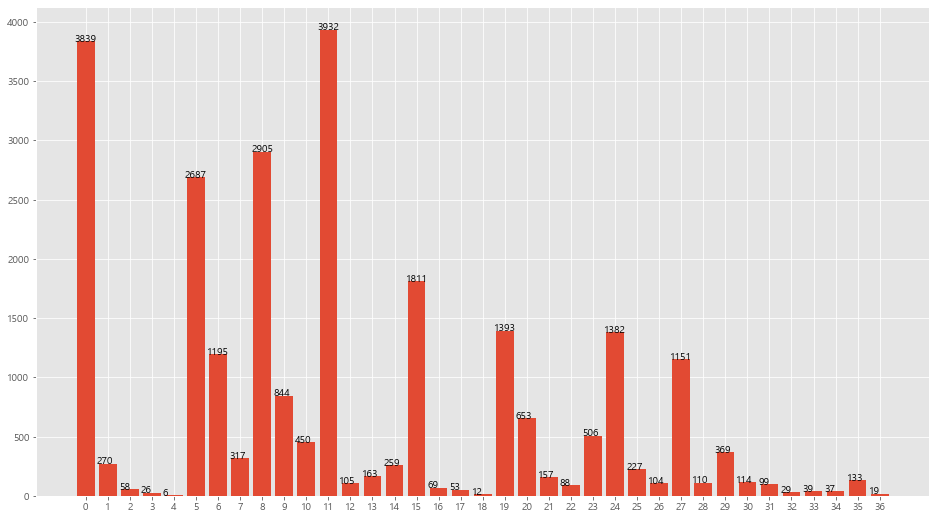

In [12]:
plt.bar(x=df_clustering["comb_cluster"].value_counts().index, height=df_clustering["comb_cluster"].value_counts().values)
for x in range(0,len(df_clustering["comb_cluster"].value_counts())):
    plt.text(x=x-.5, y=df_clustering["comb_cluster"].value_counts()[x],s=f"{df_clustering['comb_cluster'].value_counts()[x]}")
plt.xticks(range(0,len(df_clustering["comb_cluster"].value_counts())))
plt.show()

In [ ]:
# df_clustering.to_csv("./predict_result/clustering_result.csv",index=False)

# 3-1.Recommend Ver 1.

In [ ]:
#함수화
import copy
from tqdm.notebook import tqdm

##2만여명 고객 품목별 구매금액 Scale
def pivot_table_for_recommend(df_pd, df_pdc):
    df_norm = df_pd.loc[df_pdde["cust"].isin(delete_outlier_DBSCAN(df_pd, df_pdc).values.tolist())]
    df_pdde_pd_clac = df_norm.merge(df_pdc, how='left', on='pd_c')
    df_pt = pd.pivot_table(data=df_pdde_pd_clac,
                values='buy_am',
                index='cust',
                columns='clac_hlv_nm',
                aggfunc='sum',
                fill_value=0)

    df_pt.reset_index(inplace=True)

    scaler = MinMaxScaler()
    scaler.fit(df_pt.iloc[:,1:])
    df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
    df_spt_2 =  df_spt.reset_index()
    return df_spt_2


##클러스터 별로 나누는 함수 정의 필요.


##가까운 3명 뽑기 위한 dist map생성 df<-클러스터별로 나누는 함수가 들어간다.
def make_dist_map_pick_near_3(df):
    dist_map = cdist(df.iloc[:,1:], df.iloc[:,1:], metric='cosine')
    dist_map_df = pd.DataFrame(dist_map, index=df["cust"], columns=df["cust"])

    temp_dict = dict()
    for i in dist_map_df.index.tolist():
        temp_dict[i] = dist_map_df.loc[i,:].sort_values()[1:4].index.tolist()

    df_cust_near = pd.DataFrame(temp_dict)
    df_cust_near_result = df_cust_near.T

    return df_cust_near_result

def code_to_name(df :pd.DataFrame, col_name :str, df_pdc :pd.DataFrame):
    df_result = copy.deepcopy(df)
    matching_series = df_pdc.set_index("pd_c")
    df_result[col_name] = df[col_name].apply(lambda x: matching_series.loc[x, "pd_nm"])
    return df_result

def make_cust_recommend_item(df, df_pd, df_pdc, opt_pd_nm=True):
    
    recommend_dict = {}
    except_list = []

    for cust_num in tqdm(df.index):
    # sample은 이웃의 모든 구매 목록 리스트
        sample = df_pd.loc[df_pd["cust"].isin(df.loc[cust_num,:].tolist())]['pd_c'].value_counts()

    # sample_result는 이웃의 모든 구매 목록 리스트와 Target(M000261625)의 구매 목록 리스트를 비교해 Target이 구매하지 않은 품목을 찾음
        sample_result = set(sample.index)-set(df_pd.loc[df_pdde['cust']==cust_num]['pd_c'].values)

    # df_smp
        df_smp = pd.DataFrame()
        df_smp["neighbor_list"] = list(sample_result)
        df_smp["neighbor_buy_am"] = list(map(lambda x: sample[x] ,list(sample_result)))
        if opt_pd_nm:
            df_smp_nm = code_to_name(df_smp.sort_values("neighbor_buy_am", ascending=False), "neighbor_list", df_pdc)
        else:
            df_smp_nm = copy.deepcopy(df_smp)
        try:
            # sample_dff = pd.DataFrame(df_smp_nm, "neighbor_list", df_pd_clac)[0:3]['neighbor_list'].T
            sample_dff = df_smp_nm.iloc[:5,0].values.tolist()
            recommend_dict[cust_num] = sample_dff
        except:
            except_list.append((cust_num,len(df_smp_nm.iloc[:,0].values)))
            continue

    final_result_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in recommend_dict.items() ]))
    final_df = final_result_df.T

    return final_df, except_list

In [ ]:
# df_normal_dist = pivot_table_for_recommend(df_pdde, df_pd_clac)
df_normal_dist = pivot_table_for_recommend(df_pdde, df_pd_clac)

cluster_recommend_dict = dict()
cluster_exception = dict()

for clust_no in tqdm(df_clustering["comb_cluster"].unique()):
    ## -- 클러스터 1개 당 df 정의
    clust_list = df_clustering.loc[df_clustering["comb_cluster"]==clust_no]["cust"].values.tolist()
    df_similar = df_normal_dist.loc[df_normal_dist["cust"].isin(clust_list)]
    
    ## PRODUCT NAME
    cluster_recommend_dict[clust_no], cluster_exception[clust_no] = make_cust_recommend_item(make_dist_map_pick_near_3(df_similar),df_pdde, df_pd_clac, True)
    ## PRODUCT CODE
    # cluster_recommend_dict[clust_no], cluster_exception[clust_no] = make_cust_recommend_item(make_dist_map_pick_near_3(df_similar),df_pdde, df_pd_clac, False)
    
c_rd = copy.deepcopy(cluster_recommend_dict)
c_ex = copy.deepcopy(cluster_exception)

In [ ]:
c_rd[0]
# pd.DataFrame(c_ex)

,0,1,2
M000261625,기타남성의류세트,남성스포츠티셔츠,기타건과일
M000508243,기타남성의류세트,성인침구세트,한식
M001694463,즉석무침반찬,젤리,양식
M001697472,국산담배,수입맥주,국물용기라면
M001729158,종량제봉투,생활잡화균일가,일반스낵
...,...,...,...
M998346579,여성티셔츠/탑,디저트,젤리
M999213998,비빔봉지라면,방울토마토,냉동떡볶이
M999227380,기타아웃도어/레저용품,기타파티/팬시용품,남성티셔츠
M999340261,기타컴퓨터액세서리,키보드,국산담배


# 3-2.Recommend Ver 2.

In [18]:
#함수화
import copy
from tqdm.notebook import tqdm

##2만여명 고객 품목별 구매금액 Scale
def pivot_table_for_recommend(df_pd, df_pdc):
    df_norm = df_pd.loc[df_pd["cust"].isin(delete_outlier_DBSCAN(df_pd, df_pdc).values.tolist())]
    df_pdde_pd_clac = df_norm.merge(df_pdc, how='left', on='pd_c')
    df_pt = pd.pivot_table(data=df_pdde_pd_clac,
                values='buy_am',
                index='cust',
                columns='clac_hlv_nm',
                aggfunc='sum',
                fill_value=0)

    df_pt.reset_index(inplace=True)

    scaler = MinMaxScaler()
    scaler.fit(df_pt.iloc[:,1:])
    df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
    df_spt_2 =  df_spt.reset_index()
    return df_spt_2


##클러스터 별로 나누는 함수 정의 필요.
def find_nearest_3(df_clust, df_normal_dist, clust_no, opt_test=None):
    
    clust_list = df_clust.loc[df_clust["comb_cluster"]==clust_no]["cust"].values.tolist()
    df_similar = df_normal_dist.loc[df_normal_dist["cust"].isin(clust_list)]

    dist_map = cdist(df_similar.iloc[:,1:], df_similar.iloc[:,1:], metric='cosine')
    near_indexes = dist_map.argsort()[:,1:4]
    near_loc_idx = [list(map(lambda x: df_similar.iloc[x,0], near_idx)) for near_idx in near_indexes]
    df_near = pd.DataFrame(near_loc_idx, index=df_similar["cust"].values)
    if opt_test is not None: return df_near.loc[opt_test["cust"].unique().tolist(),:]
    else: return df_near


def code_to_name(df :pd.DataFrame, col_name :str, df_pdc :pd.DataFrame):
    df_result = copy.deepcopy(df)
    matching_series = df_pdc.set_index("pd_c")
    df_result[col_name] = df[col_name].apply(lambda x: matching_series.loc[x, "pd_nm"])
    return df_result

def make_cust_recommend_item(df_near, df_pd, df_pdc, opt_pd_nm=True):
    
    recommend_dict = {}
    except_list = []

    for cust_num in df_near.index:
    # sample은 이웃의 모든 구매 목록 리스트
        sample = df_pd.loc[df_pd["cust"].isin(df_near.loc[cust_num,:].tolist())]['pd_c'].value_counts()

    # sample_result는 이웃의 모든 구매 목록 리스트와 Target(M000261625)의 구매 목록 리스트를 비교해 Target이 구매하지 않은 품목을 찾음
        sample_result = set(sample.index)-set(df_pd.loc[df_pdde['cust']==cust_num]['pd_c'].values)

    # df_smp
        df_smp = pd.DataFrame()
        df_smp["neighbor_list"] = list(sample_result)
        df_smp["neighbor_buy_am"] = list(map(lambda x: sample[x] ,list(sample_result)))
        if opt_pd_nm:
            df_smp_nm = code_to_name(df_smp.sort_values("neighbor_buy_am", ascending=False), "neighbor_list", df_pdc)
        else:
            df_smp_nm = copy.deepcopy(df_smp)
        try:
            # sample_dff = pd.DataFrame(df_smp_nm, "neighbor_list", df_pd_clac)[0:3]['neighbor_list'].T
            sample_dff = df_smp_nm.iloc[:5,0].values.tolist()
            recommend_dict[cust_num] = sample_dff
        except:
            except_list.append((cust_num,len(df_smp_nm.iloc[:,0].values)))
            continue

    final_result_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in recommend_dict.items() ]))
    final_df = final_result_df.T

    return final_df, except_list

In [14]:
df_normal_dist = pivot_table_for_recommend(df_pdde, df_pd_clac)

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
cluster_recommend_dict = dict()
cluster_exception = dict()
# df_test_clust = df_clustering.merge(df_test, "left", "cust").dropna(subset=["comb_cluster"])

for clust_no in tqdm(df_clustering["comb_cluster"].unique()):
    # df_test_c = df_test_clust.loc[df_test_clust["comb_cluster"]==clust_no]
    # near_3cust = find_nearest_3(df_clustering, df_normal_dist, clust_no, opt_test=df_test_c)
    near_3cust = find_nearest_3(df_clustering, df_normal_dist, clust_no)
    cluster_recommend_dict[clust_no], cluster_exception[clust_no] = make_cust_recommend_item(near_3cust, df_pdde, df_pd_clac, True)
    
c_rd = copy.deepcopy(cluster_recommend_dict)
c_ex = copy.deepcopy(cluster_exception)

  0%|          | 0/37 [00:00<?, ?it/s]

In [26]:
import pickle
from datetime import datetime

with open(f"./predict_result/recommend_dict_{datetime.today().strftime('%y%m%d%H%M%S')}.pickle", "wb") as f:
    pickle.dump(c_rd, f, pickle.HIGHEST_PROTOCOL)
    
with open(f"./predict_result/exception_list_{datetime.today().strftime('%y%m%d%H%M%S')}.pickle", "wb") as f:
    pickle.dump(c_ex, f, pickle.HIGHEST_PROTOCOL)

In [25]:
c_rd[30]

,0,1,2,3,4
M002867247,남성등산/아웃도어세트,양파,중국술,일반스낵,과실차
M009682567,기타파티/팬시용품,남성스포츠티셔츠,기타전통과자,일반미,쌈채소류
M025168868,쿠키,기타파티/팬시용품,일반요구르트,하드캔디,샌드
M035670981,남성스포츠티셔츠,일반스낵,종량제봉투,양념소스,일반계란
M036380438,스포츠양말,남성등산점퍼/재킷,남성등산바지,여성바지,남성스포츠점퍼/재킷
...,...,...,...,...,...
M968577686,수입담배,종량제봉투,가공조미료,남아의류세트,파우치/즉석음료
M976769449,일반스낵,남성골프티셔츠,일반계란,남성스포츠티셔츠,식빵
M977028904,커피/음료,남성트레이닝복,기타파티/팬시용품,쇼핑백,남성일반스포츠바지
M980307010,일반우유,애호박,크래커,볶음반찬,남성티셔츠


# 4.Concat result

In [35]:
pd.concat(c_rd.values(), axis=0).to_csv("./predict_result/total_recommend.csv", encoding="euc-kr")